# Analysis of Performance Variables

## Task Performance I: Sum of Degrees of Freedom
The first performance variable is the radius of the white circle, which is the sum of both degrees of freedom. The target is 125.

In [1]:
# Basic imports and setup.

import sys
import logging
from pathlib import Path

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from neuropsymodelcomparison.dataprocessing import analysis
from neuropsymodelcomparison import plot

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Default file format for figures.
pio.kaleido.scope.default_format = "pdf"

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Get preprocessed trials data.

In [2]:
data_path = Path('../data/preprocessed')
reports_path = Path('../reports')

trials_filepath = data_path / 'trials.csv'
df = pd.read_csv(trials_filepath, index_col='id', dtype={'outlier': bool, 'exclude': bool})
# Clear outliers and excluded trials.
df = df.loc[~(df['outlier'] | df['exclude'])].drop(['outlier', 'exclude'], axis='columns')
# Easier on memory and faster groupby.
df[['user', 'session', 'block', 'block_id', 'condition', 'task']] = df[['user', 'session', 'block', 'block_id', 'condition', 'task']].astype('category')

# When we view statistics by task, we want them to to be displayed in a certain order.
task_display_order = ['pre', 'df1', 'df2', 'df1|df2', 'post']
df.task.cat.reorder_categories(task_display_order, inplace=True)
condition_display_order = ['df1', 'df2', 'df1|df2']
df.condition.cat.reorder_categories(condition_display_order, inplace=True)

In [3]:
df_block_stats = pd.read_csv(reports_path / 'block_stats.csv', index_col='block_id', dtype={'exclude': bool})
df_block_stats = df_block_stats.loc[~df_block_stats['exclude']].drop('exclude', axis='columns')
df_block_stats[['user', 'session', 'condition', 'block', 'task']] = df_block_stats[['user', 'session', 'condition', 'block', 'task']].astype('category')
df_block_stats.head()

user session condition block     task  count  df1 mean  df1 variance  \
block_id                                                                        
28          9       1   df1|df2     1      pre     28  57.28674       1.89659   
29          9       1   df1|df2     2  df1|df2     29  61.34115       2.95729   
30          9       1   df1|df2     3     post     30  59.04823      10.08157   
31         10       1   df1|df2     1      pre     20  64.67744      14.66680   
32         10       1   df1|df2     2  df1|df2     23  62.73914      12.69344   

          df2 mean  df2 variance  df1,df2 covariance  sum mean  sum variance  \
block_id                                                                       
28        66.29423       2.37102            -1.67026 123.58098       0.92708   
29        61.49874      32.29306            -1.11388 122.83990      33.02260   
30        64.72594      26.39846           -15.88667 123.77417       4.70668   
31        60.86131      12.46357           -12.21433 125.53875       2.70171   
32        60.77137       4.94527            -1.20899 123.51050      15.22073   

          parallel absolute average  parallel variance  \
block_id                                                 
28                          1.52366            3.80407   
29                          2.30096           18.73906   
30                          2.67035           34.12669   
31                          4.20297           25.77952   
32                          2.44603           10.02834   

          orthogonal absolute average  orthogonal variance      dV     dVz  \
block_id                                                                     
28                            0.55278              0.46354 1.56553 1.05247   
29                            2.10496             16.51130 0.12640 0.06328   
30                            0.78705              2.35334 1.74196 1.33712   
31                            0.81204              1.35086 1.80084 1.47442   
32                            2.13391              7.61037 0.27417 0.13795   

          rating  
block_id          
28             0  
29             1  
30             0  
31             2  
32             3

## Difficulty Rating

In [4]:
fig_rating_by_block = px.line(df_block_stats, x='block', y='rating', line_group='user', line_dash='condition', color='condition', category_orders={'condition': condition_display_order}, labels={'block': 'Block', 'rating': 'Difficulty Rating', 'condition': 'Condition'}, height=500)
fig_rating_by_block.update_yaxes(hoverformat='.2f', tickvals=df_block_stats['rating'].unique(), ticktext=['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
fig_rating_by_block.update_xaxes(tickvals=df_block_stats['block'].unique(), range=[df_block_stats['block'].unique().as_ordered().min()-0.2, df_block_stats['block'].unique().as_ordered().max()+0.2])
legend = go.layout.Legend(xanchor='right',
                          yanchor='top',
                          orientation='v',
                          title="Condition")
fig_rating_by_block.update_layout(margin=plot.theme['graph_margins'], legend=legend)
fig_rating_by_block.show()

Participants differ in how they perceived the difficulty of the tasks. Some individuals perceived the different tasks across the experimental blocks as equally difficult. But others rated block 2, in which the constrained task was to be performed, as more difficult than the unconstrained tasks. When performing the unconstrained task for the second time, participants gave similar ratings as for the first time.

### Does difficulty rating correlate with performance?

In [5]:
fig_rating_vs_var = px.scatter(df_block_stats, x='rating', y='sum variance', color='condition', category_orders={'condition': condition_display_order},
                               hover_data=['user', 'block'])
legend = go.layout.Legend(xanchor='right',
                          yanchor='top',
                          orientation='v',
                          title="Condition")
fig_rating_vs_var.update_yaxes(hoverformat='.2f')
fig_rating_vs_var.update_xaxes(tickvals=df_block_stats['rating'].unique(), ticktext=['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
fig_rating_vs_var.update_layout(margin=plot.theme['graph_margins'], legend=legend)
fig_rating_vs_var.show()

In [6]:
sumvar_rating_levene = pg.homoscedasticity(df_block_stats, dv='sum variance', group='rating')
sumvar_rating_levene

W    pval  equal_var
levene 4.68415 0.00183      False

We can see that the variance of the performance variable increases on average with the difficulty rating. The variance in the residuals increases with the rating. An equidistance between the ratings is not guaranteed. Using a simple linear regression model to analyze this heteroscedastic data would, therefore, not be appropiate.

## Distribution
Let's first look at the mean final states in relation to the task goals.

In [7]:
fig_mean_scatter = px.scatter(df_block_stats, x='df1 mean', y='df2 mean', symbol='block', color='task',
                              category_orders={'task': task_display_order}, #labels={'df1 mean': 'df1', 'df2 mean': 'df2', 'sum mean': 'sum'},
                              hover_data={'user': True, 'sum variance': ':.2f', 'sum mean': ':.2f', 'rating': ':d'})
# Task goal 1 visualization.
fig_mean_scatter.add_scatter(
    x=[25, 100],
    y=[100, 25],
    mode='lines',
    name="task goal 1",
    marker={'color': 'black',
            },
    opacity=0.5,
    hovertemplate="df1+df2=125",
)
# Task goal 2 (DoF constrained) visualization.
fig_mean_scatter.add_scatter(y=[62.5], x=[62.5],
                name="task goal 2",
                hovertemplate="df1=df2=62.5",
                mode='markers',
                marker_symbol='x',
                opacity=0.5,
                marker={'size': 15,
                        'color': 'black'})
fig_mean_scatter.update_xaxes(hoverformat='.2f', title='Degree of Freedom 1', range=[0, 100], constrain='domain')
fig_mean_scatter.update_yaxes(hoverformat='.2f', title='Degree of Freedom 2', range=[0, 100], scaleanchor='x', scaleratio=1)
legend = go.layout.Legend(
        xanchor='right',
        yanchor='top',
        orientation='v',
        title="Task, Block"
    )
fig_mean_scatter.update_layout(margin=plot.theme['graph_margins'], legend=legend, width=540)
fig_mean_scatter.show()

As we can see, the final state mean values for the unconstrained tasks are more spread out along the solution space across participants.  
On visual inspection the constrained tasks seem to be less precise on average, as there are more mean values further away in the task relevant direction from the solution than for the unconstrained tasks.

### Normality Inspections

QQ-plots for comparing final states distribution of degrees of freedom to normal distributions.

The Filliben’s formula was used to estimate the theoretical quantiles for all QQ-plots.

In [8]:
# Interactive plot for exploration.
fig_qq_sum = plot.generate_qq_plot(df, vars_=['sum'], width=1000)
fig_qq_sum.show()

#### With Confidence Intervals

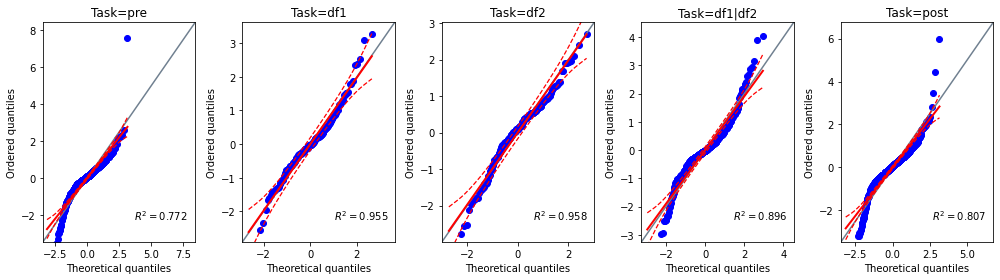

In [9]:
fig_qq_sum_ci, axes = plt.subplots(1, len(task_display_order), figsize=(14, 4))
for i, task in enumerate(task_display_order):
    pg.qqplot(df[df['task'] == task]['sum'], dist='norm', ax=axes[i])
    axes[i].set_title(f"Task={task}")
fig_qq_sum_ci.tight_layout()
plt.savefig(reports_path / 'figures/qq-plot-sum_ci.pdf')

### Histogram

In [10]:
fig_hist_sum = plot.generate_histograms(df[['task', 'sum']], by='task', x_title="Final State Sum Values", legend_title="Block Type", width=1000)
fig_hist_sum.show()

The sum of dregrees of freedom for the different tasks does not seem to be normally distributed across all participants.

### Statistics

In [11]:
sum_stats = df.groupby('task')['sum'].describe().T[task_display_order]
sum_stats

task        pre       df1       df2   df1|df2      post
count 833.00000 166.00000 210.00000 437.00000 843.00000
mean  124.35773 126.31598 122.07021 124.85365 124.44223
std     3.75687   7.69795   8.18154   6.14927   2.99102
min    91.20028  98.22780  90.53242  92.44116  95.85252
25%   123.29594 122.35520 118.31740 122.82499 123.35598
50%   124.64788 126.09282 122.90841 124.74235 124.58751
75%   126.14437 129.99542 126.77852 127.50000 125.85019
max   152.93427 151.40845 144.01408 149.76525 142.30769

### Visualisations of Means and Variability

In [12]:
# Use a barplot instead of a boxplot, because it more clearly conveys the core statistics we're interested in.
fig_sum_stats = px.bar(sum_stats.T.reset_index(), x='task', y='mean', error_y='std', labels={'mean': 'Sum Mean', 'task': 'Task'}, width=500)
fig_sum_stats.add_trace(go.Scatter(x=[task_display_order[0], task_display_order[-1]],
                                   y=[125, 125],
                                   name=f"Target",
                                   showlegend=True,
                                   hovertext=f'Target',
                                   hoverinfo='y',
                                   textposition='top center',
                                   mode='lines',
                                   marker={'color': 'red'}
                                   )
                        )
fig_sum_stats.show()

The lower variance for the distribution of the sum in pre and post tests suggest a greater stability in the performance variable when no additional task is present. Since the pre- and post-test data encompasses all participants, there are more samples in these tasks. Let's look at the statistics for individal conditions.

In [13]:
sum_stats_by_condition = df.groupby(['condition', 'block'], sort=False, observed=True)['sum'].agg(['mean', 'std', 'count']).loc[condition_display_order]
fig_sum_by_condition = px.bar(sum_stats_by_condition.reset_index(), x='block', y='mean', error_y='std', facet_col='condition', labels={'mean': 'Sum Mean', 'block': 'Block'}, category_orders={'condition': ['df1', 'df2', 'df1|df2']})
for col in range(1, sum_stats_by_condition.index.unique(level='condition').size + 1):
    fig_sum_by_condition.add_trace(go.Scatter(
                                    x=[0.5, 3.5],
                                    y=[125, 125],
                                    name=f"Target",
                                    showlegend=col==1,
                                    hovertext=f'Target',
                                    hoverinfo='y',
                                    textposition='top center',
                                    mode='lines',
                                    marker={'color': 'red'}
                                    ), row=1, col=col
                            )
fig_sum_by_condition.show()
sum_stats_by_condition

mean     std  count
condition block                         
df1       1     124.55622 4.00922    165
          2     126.31598 7.69795    166
          3     124.20888 2.22433    167
df2       1     124.71939 3.13675    225
          2     122.07021 8.18154    210
          3     123.97816 3.86583    226
df1|df2   1     124.10011 3.93312    443
          2     124.85365 6.14927    437
          3     124.76189 2.68837    450

When looking at the conditions individually, we can still see a consistent pattern of larger variability in the treatment block for the sum of both degrees of freedom. This suggests a destabilization of the performance variable when an additional task is introduced. We've seen that for the various tasks different motor strategies were employed. Since we observe an increase in the variability of task performance in the treatment block for all conditions, this increase may not be attributable to any particular motor strategy, but to the mere presence of an additional task and stimulus material.

#### By Participant

In [14]:
fig_sum_by_user = plot.generate_means_figure(df_block_stats, width=1000)
fig_sum_by_user.show()

## Task Performance II: Mean final state difference
The difference in mean values of degrees of freedom is the performance variable for the additional task, since the solution to the treatment tasks is that both degrees of freedom are at 62.5.

###   Difference from target value per degree of freedom

In [15]:
target_diff = df[['user', 'block', 'condition', 'task', 'df1', 'df2']]
target_diff[['df1', 'df2']] = target_diff[['df1', 'df2']] - 62.5

fig_target_diff_hist = plot.generate_histogram_rows(target_diff.loc[df['block']==2].drop(['user', 'block', 'task'], axis='columns'), x_title="Difference to Target", rows='condition', legend_title="Variable")
fig_target_diff_hist.show()
target_diff.loc[target_diff['block']==2].groupby(['condition', 'block'], observed=True).agg(['mean', 'std'])

df1              df2        
                    mean     std     mean     std
condition block                                  
df1|df2   2     -0.95004 4.91598  0.80369 5.03996
df2       2     -2.85805 7.43017 -0.07174 4.46015
df1       2     -1.00605 3.57020  2.32204 7.69766

In [16]:
fig_target_diff_violin = plot.generate_violin_figure(target_diff, ['df1', 'df2'], "Difference to Target", legend_title="DoF", width=1000)
fig_target_diff_violin.show()

### Difference between degrees of freedom.
The intend to treat is that both degrees of freedom are equal. This may be achieved without reaching the intended target value precisely.

In [34]:
df['diff'] = df[['df1', 'df2']].diff(axis='columns').dropna(axis='columns').abs().squeeze()
dof_diff = df.groupby(['block', 'condition'], observed=True)['diff'].describe()
dof_diff

count     mean      std     min     25%     50%      75%  \
block condition                                                                
1     df1|df2   443.00000 11.15167  9.27771 0.01001 5.16812 9.77938 14.33168   
      df2       225.00000 11.44449  9.07246 0.02045 3.54302 9.04403 19.58496   
      df1       165.00000  8.70327 10.43768 0.00000 2.93156 6.22066 10.66067   
2     df1|df2   437.00000  4.82352  6.40980 0.00000 0.91859 2.26270  6.09664   
      df2       210.00000  6.89754  6.57726 0.03094 1.81263 4.43093 10.07588   
      df1       166.00000  7.25482  6.55239 0.00000 2.60258 5.39698  9.62875   
3     df1|df2   450.00000  8.81743  6.26095 0.06189 4.13515 7.75412 12.99404   
      df2       226.00000  9.39601  9.02972 0.09061 2.84568 6.22030 11.33807   
      df1       167.00000 13.72965 13.85261 0.05869 6.27003 9.86827 14.16812   

                     max  
block condition           
1     df1|df2   52.11267  
      df2       34.22781  
      df1       79.85589  
2     df1|df2   61.19922  
      df2       33.88072  
      df1       45.02520  
3     df1|df2   50.93697  
      df2       36.51793  
      df1       78.69718

In [48]:
fig_df_diff = px.box(df, x='block', y='diff', facet_col='condition', notched=True, color='block', category_orders={'condition':condition_display_order}, labels={'diff': "DoF Difference (absolute)", 'block': 'Block'}, hover_data=['user'])
fig_df_diff.update_yaxes(hoverformat='.2f')
legend = go.layout.Legend(xanchor='right',
                          yanchor='top',
                          orientation='v',
                          title="Block")
fig_df_diff.update_layout(margin=plot.theme['graph_margins'], legend=legend)
fig_df_diff.show()

#### Equivalence test
If we take a 5% error margin for the differece between degrees of freedom, that translates to a tolerance of 5 units between degrees of freedom.

In [32]:
dof_tost = df.groupby(['condition', 'block']).apply(lambda x: pg.tost(x=x['df1'], y=x['df2'], bound=5, paired=True))
dof_tost

bound  dof    pval
condition block                         
df1       1     TOST      5  164 0.44127
          2     TOST      5  165 0.01024
          3     TOST      5  166 0.99993
df2       1     TOST      5  224 0.93655
          2     TOST      5  209 0.00027
          3     TOST      5  225 0.96200
df1|df2   1     TOST      5  442 0.00000
          2     TOST      5  436 0.00000
          3     TOST      5  449 0.00823

The experimental manipulation aimed to evoke a strategy of equivalent motor commands seems to have worked for most trials. Furthermore, this strategy seems to also have been employed in unconstrained tasks by participants in the condition with feedback on both degrees of freedom. Since blocks 1 and 3 aren't any different from the other conditions, this may hint to the sensitivity of the test of equivalence to the number of samples.

We can see that the type of instructions and feedback have an influence on the bahavior of the participants. If feedback is given only for 1 degree of freedom, that degree of freedom is handled more precisely than the seemingly unconstrained degree of freedom. The new task seems to have taken precedence over the previously introduced task. In the constrained task with feedback for both degrees of freedom the precision is on average higher for both task goals. There is less difference between degrees of freedom.

# Save Reports

In [50]:
def save_report(dataframe, filename, index=True):
    """ Save dataframe as CSV to reports. """
    out_file = reports_path / filename
    dataframe.to_csv(out_file, index=index)
    logging.info(f"Written report to {out_file.resolve()}")

save_report(sum_stats_by_condition.reset_index(), 'sum_stats_by_condition.csv', index=False)
save_report(sumvar_rating_levene, 'sumvar_rating_levene.csv')
save_report(dof_diff.reset_index(), 'dof_difference.csv', index=False)
save_report(dof_tost.reset_index(), 'dof_tost.csv', index=False)

target_diff_stats = target_diff.groupby(['condition', 'block'], observed=True).agg(['mean', 'std'])
target_diff_stats.columns = [' '.join(c).strip() for c in target_diff_stats.columns]
target_diff_stats.reset_index(inplace=True)
save_report(target_diff_stats, 'dof_diff_goal2.csv', index=False)

# Save figures.
figures_path = reports_path / 'figures'

def save_fig(fig, filename):
    """ Save plotly figure to reports. """
    fig_filepath = figures_path / filename
    fig.write_image(str(fig_filepath))
    logging.info(f"Written figure to {fig_filepath.resolve()}")

# Scatter
save_fig(fig_rating_by_block, 'line-plot-rating_block.pdf')
save_fig(fig_rating_vs_var, 'scatter-rating_variance.pdf')
save_fig(fig_mean_scatter, 'scatter-sum_mean.pdf')
# QQ-Plots
save_fig(fig_qq_sum, 'qq-plot-sum.pdf')
# Histogram
save_fig(fig_hist_sum, 'histogram-sum.pdf')
save_fig(fig_target_diff_hist, 'histogram-sum.pdf')
# Violin
save_fig(fig_target_diff_violin, 'violin-target_diff.pdf')
# Barplots
save_fig(fig_sum_stats, 'barplot-sum.pdf')
save_fig(fig_sum_by_condition, 'barplot-sum_by_condition.pdf')
save_fig(fig_sum_by_user, 'barplot-sum_by_user.pdf')
save_fig(fig_df_diff, 'boxplot-dof_diff.pdf')

INFO:root:Written report to /home/olaf/code/NeuroPsyResearchAnalysis/reports/sum_stats_by_condition.csv
INFO:root:Written report to /home/olaf/code/NeuroPsyResearchAnalysis/reports/sumvar_rating_levene.csv
INFO:root:Written report to /home/olaf/code/NeuroPsyResearchAnalysis/reports/dof_difference.csv
INFO:root:Written report to /home/olaf/code/NeuroPsyResearchAnalysis/reports/dof_tost.csv
INFO:root:Written report to /home/olaf/code/NeuroPsyResearchAnalysis/reports/dof_diff_goal2.csv
INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/figures/line-plot-rating_block.pdf
INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/figures/scatter-rating_variance.pdf
INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/figures/scatter-sum_mean.pdf
INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/figures/qq-plot-sum.pdf
INFO:root:Written figure to /home/olaf/code/NeuroPsyResearchAnalysis/reports/fig